In [4]:
import pandas as pd
import numpy as np
import time




file_path = 'C:\\Users\\franc\\Desktop\\IntroCS_Project2-master\\IntroCS_Project2-master\\Code\\email-Enron.txt'

df_a = pd.read_csv(file_path,delimiter="\t",header=None) #use delimiter = "\t" for Enron dataset 
                                                         #use delimiter = "," for Git dataset
df_a = df_a.rename(columns={0:"from", 1:"to"})        


df_a_sorted = df_a.sort_values(by=["from"])
df_a.shape

n = df_a.nunique(axis=0)[0]
ordered_a_indices = np.arange(0,n,1,dtype='int')
ordered_a_indices
print(len(ordered_a_indices))

ordered_a_list = df_a_sorted["from"].unique()
ordered_a_list
len(ordered_a_list)

for j in range(0,n):
    df_a = df_a.replace(ordered_a_list[j],ordered_a_indices[j]) 
df_a_sorted = df_a.sort_values(by=['from'])

adj_a = pd.DataFrame(np.zeros(shape=[n,n]),dtype='bool')

#adj_a is now an nxn dataframe matrix, with all entries equal to "False"


#Paul added the following:

#The following code now changes appropriate elements of adj_a to "True"
#These "True" elements indicate the presence of an edge in our network
#This process has a timer also


start = time.process_time() 
for i in range(0,len(df_a_sorted)):
    adj_a[df_a_sorted.iloc[i][0]][df_a_sorted.iloc[i][1]]=True
    
    if i == int(len(df_a_sorted)*.2):
        lap = time.process_time()
        print("20% of adj matrix filled")
        print("Elapsed time = %.2f seconds\n" % (lap-start))
        
    if i == int(len(df_a_sorted)*.4):
        lap = time.process_time()
        print("40% of adj matrix filled")
        print("Elapsed time = %.2f seconds\n" % (lap-start))
        
    if i == int(len(df_a_sorted)*.6):
        lap = time.process_time()
        print("60% of adj matrix filled")
        print("Elapsed time = %.2f seconds\n" % (lap-start))
        
    if i == int(len(df_a_sorted)*.8):
        lap = time.process_time()
        print("80% of adj matrix filled")
        print("Elapsed time = %.2f seconds\n" % (lap-start))
        
    if i == int(len(df_a_sorted)-1):
        lap = time.process_time()
        print("100% of adj matrix filled")
        print("Elapsed time = %.2f seconds\n" % (lap-start))
        
        
end = time.process_time()-start 
print("It took me %.2f seconds "%(end))





36692
20% of adj matrix filled
Elapsed time = 86.33 seconds

40% of adj matrix filled
Elapsed time = 171.11 seconds

60% of adj matrix filled
Elapsed time = 249.28 seconds

80% of adj matrix filled
Elapsed time = 330.19 seconds

100% of adj matrix filled
Elapsed time = 411.56 seconds

It took me 411.56 seconds 


Poisson Distribution fit: chi_squared=265.1145428809, p=0.0000000000,lambda=10.0202223918
Power law Distribution fit: chi_squared=0.3654310731, p=1.0000000000, alpha=1.7979579252


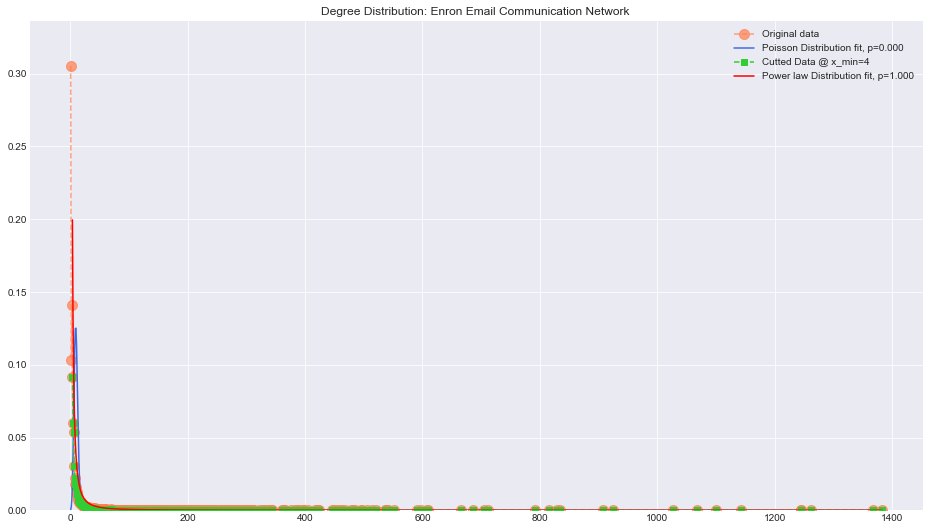

In [63]:
import pandas as pd
import numpy as np
import math
import random 
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import os

from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import powerlaw

#given a value s and an array, finds the index of the element which is the nearest to s
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#selfmade power law distribution (normalized), with support (x_min,+inf)
def powpow(x,a,x_min): #selfmade power law distribution (normalized), with support (x_min,+inf)
    if a<0:
        print("only negative powers allowed! (stoopid)") 
    if x_min<=0:
        print("only positive x_min allowed! (stoopid)")
    else:
        return (a-1)/(x_min) * 1/np.power(x/x_min,a)


    
# fitPois estimes the parameter lambda of the power law distriburion with ML method and does a goodness of fit test  
# NB: x_max must be inserted
def fitPois(adj_data):
    
    # observed relative frequencies are calculated and estime of lambda
    s = adj_data.sum(axis = 0, skipna = True)
    lbd=np.mean(s)
    f_unique_elements, f_counts_elements = np.unique(s, return_counts=True)
    observed = f_counts_elements/sum(f_counts_elements)
    x = f_unique_elements
    
    #cut-off of the tail: all data grater then x_max are included in the same class in the chisquared test
    x_max=24
    cut = find_nearest(x,x_max)
    observedcut = np.append(observed[0:cut],observed[cut:].sum())
    
    #expected frequencies are computed and chi squared test is performed
    expected = poisson.pmf(x, lbd, 0)
    expectedcut=np.append(expected[0:cut],expected[cut:].sum())
    chi_statistic, p_value = chisquare(observedcut, expectedcut)
    
    #plots
    print("Poisson Distribution fit: chi_squared=%.10f, p=%.10f,lambda=%.10f"%(chi_statistic, p_value, lbd))
    plt.figure(figsize=(16,9))
    plt.title("Degree Distribution: Enron Email Communication Network ")#Insert title for the plot
    plt.ylim(0, max(observed)*1.1)
    plt.plot(x,observed,label="Original data",markersize=10,alpha=.7,marker='o',color='coral',ls='--')
    plt.plot(x,poisson.pmf(x,lbd,0),label="Poisson Distribution fit, p=%.3f"%(p_value),color='royalblue')
    plt.legend(fontsize=12)

# fitPow estimes the parameter alpha of the power law distriburion with ML method and does a goodness of fit test 
# NB: x_min is not estimated but must be inserted
def fitPow(adj_data):
    
    # observed relative frequences are calculated
    s = adj_data.sum(axis = 0, skipna = True)
    f_unique_elements, f_counts_elements = np.unique(s, return_counts=True)
    observed = f_counts_elements/sum(f_counts_elements)
    
    #cut-off of first observations up to x_min 
    x_min=4
    x = f_unique_elements
    cut = find_nearest(x,x_min)
    x = x[cut:]
    observed = observed[cut:]
    
    #estime of parameter alpha
    len_x=len(x)
    ln_x=np.log(x)
    for i in range (0,len_x):
        ln_x[i]=ln_x[i]/x_min
    alpha=len_x/sum(ln_x)+1
    
    #cut-off of the tail: all data grater then x_max are included in the same class in the chisquared test
    x_max=100
    cut = find_nearest(x,x_max)
    observedcut = np.append(observed[0:cut],observed[cut:].sum())
    
    #expected relative frequencies are calculated and chisquared test is performed 
    expected = powpow(x, alpha,x_min) 
    expectedcut=np.append(expected[0:cut],expected[cut:].sum())
    chi_stat, p_val = chisquare(observedcut, expectedcut)
    
    #plots
    print("Power law Distribution fit: chi_squared=%.10f, p=%.10f, alpha=%.10f"%(chi_stat, p_val, alpha))
    plt.plot(x,observed,label="Cutted Data @ x_min=%d"%(x_min),marker='s',ls='--',color='limegreen')    
    plt.plot(x,powpow(x,alpha,x_min),label="Power law Distribution fit, p=%.3f"%(p_val),color='r')
    plt.legend()

fitPois(adj_a)
fitPow(adj_a)